In [1]:
!pip install -q -U keras-tuner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import kerastuner as kt
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.layers import BatchNormalization
from keras.layers.wrappers import Bidirectional

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data = pd.read_csv('/content/gdrive/My Drive/TSLA.csv', date_parser = True)

In [5]:
data.shape

(2704, 7)

In [6]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_test = data[data['Date']>='2020-01-01'].copy()

In [7]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)
data_test = data_test.drop(['Date', 'Adj Close'], axis = 1)

In [8]:
data_test[-1:]

,Open,High,Low,Close,Volume
2703,613.0,645.5,609.5,640.390015,39150700


In [9]:
day_interval=60

In [10]:
past_30_days = data_training.tail(day_interval)
df = past_30_days.append(data_test)

In [11]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [12]:
train_size = data_training.shape[0]
print(train_size)

2394


In [13]:
X_train = []
y_train = []

for i in range(day_interval, data_training.shape[0]):
    X_train.append(data_training[i-day_interval:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape

(2334, 60, 5)

In [15]:
y_train.shape

(2334,)

In [16]:
def model_builder(hp):
  model = keras.Sequential()

  hp_units = hp.Int('units', min_value=60, max_value=300, step=60)

  model.add(Bidirectional(keras.layers.LSTM(units=hp_units, unroll= True, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]))))
  model.add(PReLU())

  model.add(Bidirectional(keras.layers.LSTM(units=hp_units, unroll= True, return_sequences = True)))
  model.add(PReLU())

  model.add(Bidirectional(keras.layers.LSTM(units=hp_units)))
  model.add(PReLU())

  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=['mse'])

  return model

In [17]:
tuner = kt.Hyperband(model_builder,
            objective='val_loss',
            max_epochs=10,
            factor=3,
            directory='my_dir',
            project_name='stock_predv1')

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 21 Complete [00h 00m 57s]
val_loss: 0.0006546588847413659

Best val_loss So Far: 0.00043405077303759754
Total elapsed time: 00h 18m 25s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 240 and the optimal learning rate for the optimizer
is 0.001.



In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch))
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
59/59 [==============================] - 44s 161ms/step - loss: 0.0130 - mse: 0.0230 - val_loss: 9.2562e-04 - val_mse: 0.0026
Epoch 2/50
59/59 [==============================] - 5s 82ms/step - loss: 3.7446e-04 - mse: 8.6983e-04 - val_loss: 0.0020 - val_mse: 0.0056
Epoch 3/50
59/59 [==============================] - 5s 83ms/step - loss: 4.2439e-04 - mse: 0.0010 - val_loss: 9.7035e-04 - val_mse: 0.0027
Epoch 4/50
59/59 [==============================] - 5s 80ms/step - loss: 3.5214e-04 - mse: 8.3568e-04 - val_loss: 5.9846e-04 - val_mse: 0.0017
Epoch 5/50
59/59 [==============================] - 5s 81ms/step - loss: 2.5848e-04 - mse: 6.0005e-04 - val_loss: 4.5063e-04 - val_mse: 0.0013
Epoch 6/50
59/59 [==============================] - 5s 80ms/step - loss: 2.4245e-04 - mse: 5.8108e-04 - val_loss: 5.5262e-04 - val_mse: 0.0016
Epoch 7/50
59/59 [==============================] - 5s 82ms/step - loss: 1.4563e-04 - mse: 3.3668e-04 - val_loss: 5.7121e-04 - val_mse: 0.0016
Epoch 8/50
59

In [21]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, callbacks=[tensorboard_callback],)

Epoch 1/40
73/73 [==============================] - 42s 110ms/step - loss: 0.0813 - mse: 0.1429
Epoch 2/40
73/73 [==============================] - 5s 73ms/step - loss: 6.5256e-04 - mse: 0.0017
Epoch 3/40
73/73 [==============================] - 5s 74ms/step - loss: 4.0402e-04 - mse: 0.0010
Epoch 4/40
73/73 [==============================] - 5s 75ms/step - loss: 2.8682e-04 - mse: 7.1924e-04
Epoch 5/40
73/73 [==============================] - 5s 75ms/step - loss: 2.9903e-04 - mse: 7.5431e-04
Epoch 6/40
73/73 [==============================] - 5s 75ms/step - loss: 2.4313e-04 - mse: 6.1060e-04
Epoch 7/40
73/73 [==============================] - 5s 74ms/step - loss: 1.9677e-04 - mse: 4.8657e-04
Epoch 8/40
73/73 [==============================] - 5s 74ms/step - loss: 1.8016e-04 - mse: 4.4822e-04
Epoch 9/40
73/73 [==============================] - 5s 74ms/step - loss: 1.4856e-04 - mse: 3.6446e-04
Epoch 10/40
73/73 [==============================] - 5s 74ms/step - loss: 1.2228e-04 - mse: 3.04

In [23]:
inputs = scaler.fit_transform(df)
inputs.shape

(370, 5)

In [24]:
X_test = []
y_test = []

for i in range(day_interval, inputs.shape[0]):
    X_test.append(inputs[i-day_interval:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((310, 60, 5), (310,))

In [25]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test mse]:", eval_result)

10/10 [==============================] - 5s 35ms/step - loss: 3.8049e-04 - mse: 8.0326e-04
[test loss, test mse]: [0.0003804894513450563, 0.0008032566984184086]


In [26]:
y_pred = model.predict(X_test)

In [27]:
y_pred.shape

(310, 1)

In [28]:
#Put last 60 day price to a input
tmr = np.array([inputs[-60:]])
tmr.shape

(1, 60, 5)

In [29]:
#denormalization
scale = 1/scaler.scale_[0]
scale

845.4200060000001

In [30]:
#denormalization
y_pred = y_pred*scale
y_test = y_test*scale

In [31]:
y_pred.shape,y_test.shape

((310, 1), (310,))

In [32]:
#Last of data
y_test[-1]

567.040001

In [33]:
#Last of chart predict result
y_pred[-1][0]

577.666

In [34]:
print("the next day price")
print(model.predict(tmr)[0][0]*scale)

the next day price
575.5686595781071


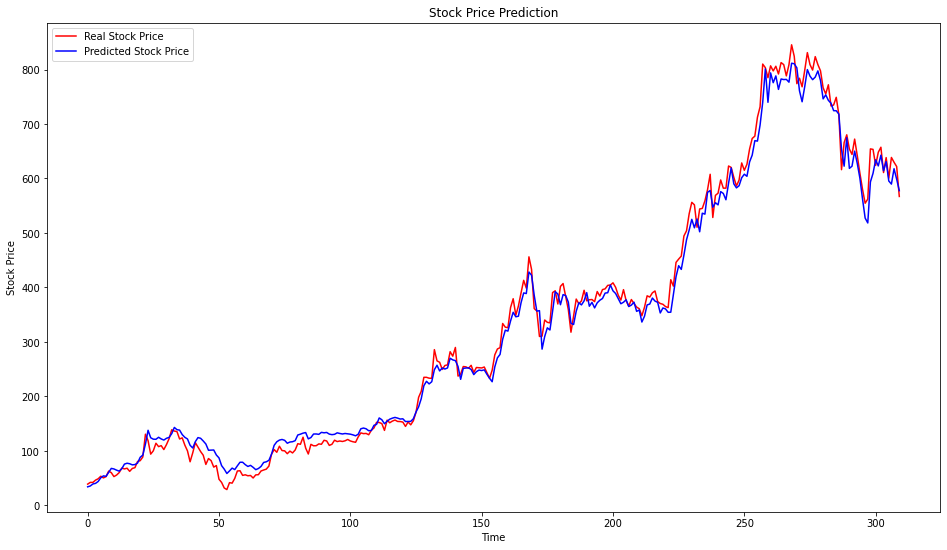

In [35]:
# Visualising the results
plt.figure(figsize=(16,9))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
!kill 9936
%load_ext tensorboard
%tensorboard --logdir my_dir

Reusing TensorBoard on port 6007 (pid 10503), started 1:33:55 ago. (Use '!kill 10503' to kill it.)

<IPython.core.display.Javascript object>